In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

M=3577297
query_type = "quantil"
TARGETS = [0, 3, 4, 5, 6, 7]
EPS = [0.01, 0.05, 0.1, 0.2]
BASE_IMG = f"../img/{query_type.upper()}_"

def add_flame_data(df, t, e):
    if (e == 0):
        profile_file = f"../data/baseline_profile_{query_type}_t_{t}.csv"
        class_name = "GKbaseline"
    else :
        profile_file = f"../data/profile_t_{t}_e_{e}.csv"
        class_name = "GK"
    
    flame = []
    with open(profile_file, "r") as file_object:
        for line in file_object:
            flame.append(line.strip())
    df_flame = pd.DataFrame(flame, columns=["call"])
    df_flame['target'] = t
    df_flame['epsilon'] = e
    #df_flame = pd.concat(df_flame)
    df_flame["call"] = df_flame["call"].astype("string")
    df_flame["call"].replace({None: ""}, inplace=True)
    df_flame["num"] = df_flame["call"].apply(lambda x: x.split(";")[-1].split(" ")[-1])
    df_flame["num"] = pd.to_numeric(df_flame["num"], errors="coerce")
    
    total = df_flame[(df_flame["target"] == t) & (df_flame["epsilon"] == e) ]["num"].sum()
    df["proc_update"] = df_flame[df_flame["call"].str.contains(f"{class_name}.update")]["num"].sum()/total
    df["proc_updatePure"] = df_flame[df_flame["call"].str.contains(f"gk/GK.updatePure")]["num"].sum()/total
    df["proc_compress"] = df_flame[df_flame["call"].str.contains(f"gk/GK.compress")]["num"].sum()/total
    df["proc_javaIO"] = df_flame[df_flame["call"].str.contains("java.io")]["num"].sum()/total
    df["proc_queryRank"] = df_flame[df_flame["call"].str.contains(f"{class_name}.rank")]["num"].sum()/total
    return df

In [2]:
###Baseline###
df_list = []
for t in TARGETS:
    
    dres = pd.read_csv(f"../data/BASELINE_{query_type.upper()}_T_{t}.csv", names=[query_type, "rank"])
    dres[query_type] = dres[query_type].str.replace("(", "").astype("int")
    dres["rank"] = dres["rank"].str.replace(")", "").astype("int")

    dquery = pd.read_csv(f"../data/INPUT_query_{query_type}.csv", names=["query_val"])

    df = pd.concat([dres,dquery], axis=1)
    df['target'] = t
    
    dtime = pd.read_csv("../data/baseline_gk_trace.csv")
    print(dtime.iloc[0])
    df = df.set_index('target').join(dtime[dtime["query"]==query_type].set_index('target'))
    
    df['tempo_inicio'] = df['tempo_inicio'].astype('datetime64[ns]')
    df['tempo_fim'] = df['tempo_fim'].astype('datetime64[ns]')
    df['tempo_exec'] = df['tempo_fim'] - df['tempo_inicio']
    df.drop(['tempo_inicio', 'tempo_fim'], axis=1, inplace=True)
    df = add_flame_data(df,t,0)
    
    df_list.append(df.reset_index())
df_base = pd.concat(df_list)

target                                             0
query                                           rank
tamanho                                      1522917
tempo_queries                           35671.881196
tempo_inicio     2021-08-21 00:30:31.193397438-03:00
tempo_fim        2021-08-21 00:31:10.756190936-03:00
Name: 0, dtype: object
target                                             0
query                                           rank
tamanho                                      1522917
tempo_queries                           35671.881196
tempo_inicio     2021-08-21 00:30:31.193397438-03:00
tempo_fim        2021-08-21 00:31:10.756190936-03:00
Name: 0, dtype: object
target                                             0
query                                           rank
tamanho                                      1522917
tempo_queries                           35671.881196
tempo_inicio     2021-08-21 00:30:31.193397438-03:00
tempo_fim        2021-08-21 00:31:10.756190936-03:00


/tmp/ipykernel_22500/2458734458.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dres[query_type] = dres[query_type].str.replace("(", "").astype("int")
/tmp/ipykernel_22500/2458734458.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dres["rank"] = dres["rank"].str.replace(")", "").astype("int")


In [3]:
###GK###
df_list = []
for t in TARGETS:
    for e in EPS:
        dres = pd.read_csv(f"../data/GK_{query_type.upper()}_T_{t}_E_{e}.csv", names=[query_type,"rank"])
        dres[query_type] = dres[query_type].str.replace("(","").astype('int')
        dres["rank"] = dres["rank"].str.replace(")","").astype('int')
        # .. _t_{t}.csv
        dquery = pd.read_csv(f"../data/INPUT_query_{query_type}.csv", names=["query_val"])
        
        df = pd.concat([dres,dquery], axis=1)
        df['target'] = t
        df['epsilon'] = e
        df = df.set_index(["target", "epsilon"])
        
        dtime = pd.read_csv("../data/gk_profile_trace.csv")
        dtime = dtime.set_index(['target', 'epsilon'])
        df = df.join(dtime[dtime["query"] == query_type])
        
        df['tempo_inicio'] = df['tempo_inicio'].astype('datetime64[ns]')
        df['tempo_fim'] = df['tempo_fim'].astype('datetime64[ns]')
        df['tempo_exec'] = df['tempo_fim'] - df['tempo_inicio']
        df.drop(['tempo_inicio', 'tempo_fim'], axis=1, inplace=True)
        
        df = add_flame_data(df,t,e)
        df_list.append(df.reset_index())
df_gk = pd.concat(df_list)

/tmp/ipykernel_22500/3105324447.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dres[query_type] = dres[query_type].str.replace("(","").astype('int')
/tmp/ipykernel_22500/3105324447.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dres["rank"] = dres["rank"].str.replace(")","").astype('int')


In [4]:
df_base = df_base.set_index(["target", "query_val"])
df_base["epsilon"] = 0
df_gk = df_gk.set_index(["target", "query_val"])

#df_base["erro"] = abs(df_base["rank"] - df_base["rank"] )
#df_base["erro_max"] =  df_base["epsilon"] * M

#df_gk["erro"] = abs(df_gk["rank"] - df_gk["rank"] )
#df_gk["erro_max"] =  df_gk["epsilon"] * M

df = df_base.join(df_gk, lsuffix="_baseline")
#df = df_gk

In [5]:
df.dtypes

quantil_baseline                      int64
rank_baseline                         int64
query_baseline                       object
tamanho_baseline                      int64
tempo_queries_baseline              float64
tempo_exec_baseline         timedelta64[ns]
proc_update_baseline                float64
proc_updatePure_baseline            float64
proc_compress_baseline              float64
proc_javaIO_baseline                float64
proc_queryRank_baseline             float64
epsilon_baseline                      int64
epsilon                             float64
quantil                               int64
rank                                  int64
query                                object
tamanho                               int64
tempo_queries                       float64
tempo_exec                  timedelta64[ns]
proc_update                         float64
proc_updatePure                     float64
proc_compress                       float64
proc_javaIO                     

In [6]:
print(df.columns)
df["erro"] = abs(df[f"rank_baseline"] - df["rank"] )
df["erro_max"] =  df["epsilon"] * M

#df_gk = df_gk.reset_index()
#df_base = df_base.reset_index()

df = df.reset_index()

len(df)

Index(['quantil_baseline', 'rank_baseline', 'query_baseline',
       'tamanho_baseline', 'tempo_queries_baseline', 'tempo_exec_baseline',
       'proc_update_baseline', 'proc_updatePure_baseline',
       'proc_compress_baseline', 'proc_javaIO_baseline',
       'proc_queryRank_baseline', 'epsilon_baseline', 'epsilon', 'quantil',
       'rank', 'query', 'tamanho', 'tempo_queries', 'tempo_exec',
       'proc_update', 'proc_updatePure', 'proc_compress', 'proc_javaIO',
       'proc_queryRank'],
      dtype='object')


2400

In [7]:
df[[ query_type, f"{query_type}_baseline"]] = df[[ query_type, f"{query_type}_baseline"]] +1

In [8]:
B = 1000000000
df["tempo_queries"] = df["tempo_queries"].astype('float')

df["tempo_exec_seg"] = df["tempo_exec"].view("int")/B

df["tempo_update"] = df["proc_update"] * df["tempo_exec_seg"]
df["tempo_query"] = df["proc_queryRank"] * df["tempo_exec_seg"]
df["tempo_io"] = df["proc_javaIO"] * df["tempo_exec_seg"]

df["tempo_exec_seg_baseline"] = df["tempo_exec_baseline"].view("int")/B


df["tempo_update_baseline"] = df["proc_update_baseline"] * df["tempo_exec_seg_baseline"]
df["tempo_query_baseline"] = df["proc_queryRank_baseline"] * df["tempo_exec_seg_baseline"]
df["tempo_io_baseline"] = df["proc_javaIO_baseline"] * df["tempo_exec_seg_baseline"]

In [9]:
#TODO tempo para montar estrutura
df_heatMap = df.drop_duplicates(subset=["epsilon", "target"])

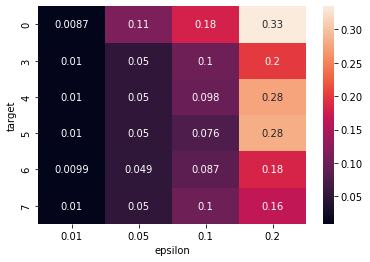

In [10]:
n_col = "erro"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot/M, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

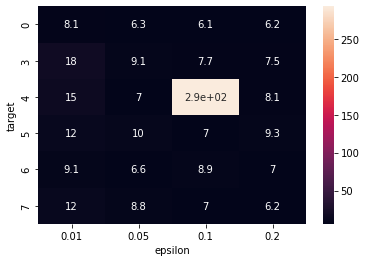

In [11]:
n_col = "tempo_queries"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

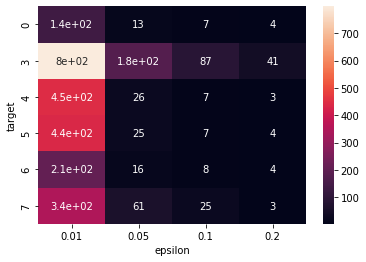

In [12]:
n_col = "tamanho"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

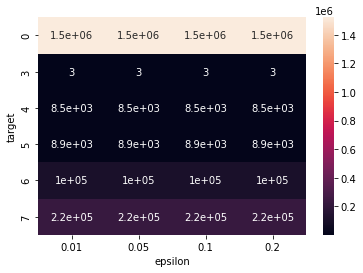

In [13]:
n_col = "tamanho_baseline"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

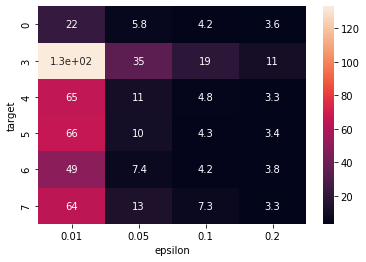

In [14]:
n_col = "tempo_exec_seg"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

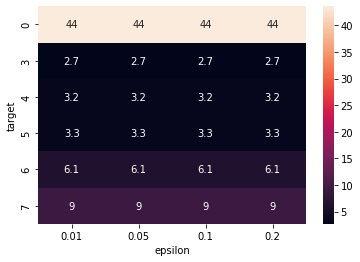

In [15]:
n_col = "tempo_exec_seg_baseline"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

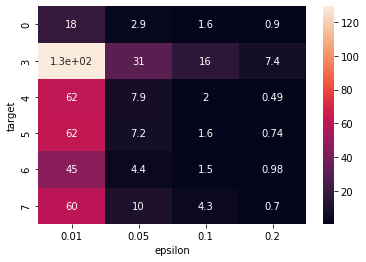

In [16]:
n_col = "tempo_update"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

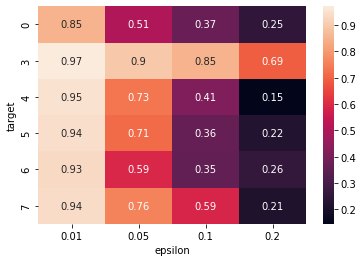

In [17]:
n_col = "proc_update"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

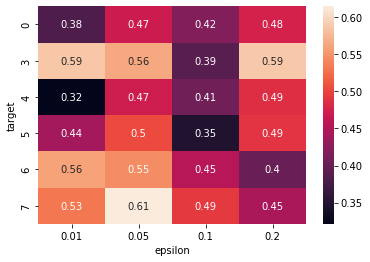

In [18]:
n_col = "tempo_io"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

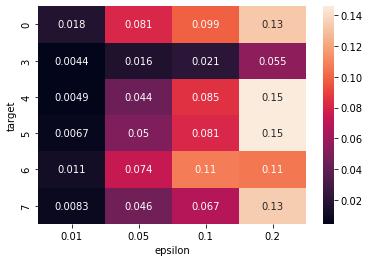

In [19]:
n_col = "proc_javaIO"

pivot = df_heatMap.groupby(["target", "epsilon"])[n_col].mean().reset_index().pivot("target", "epsilon", n_col)
f = sns.heatmap(pivot, annot=True)

f.get_figure().savefig(f"{BASE_IMG}heatmap_{n_col.upper()}")

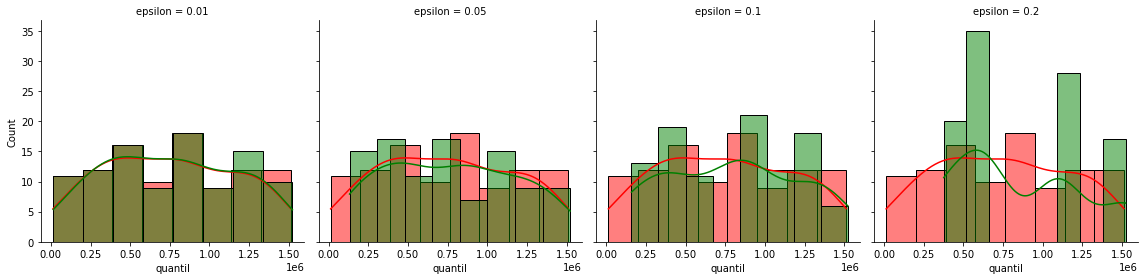

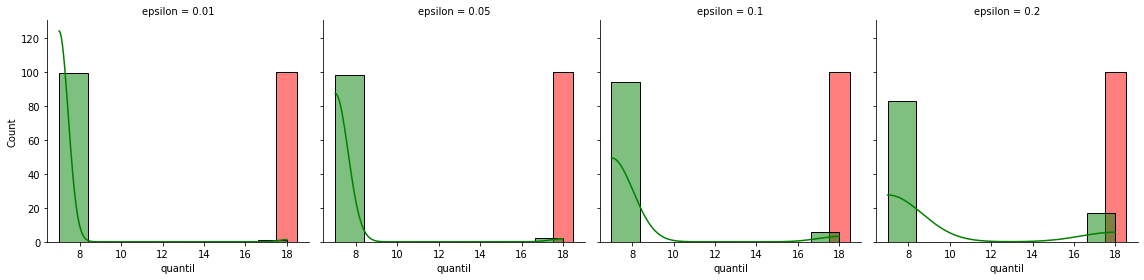

In [28]:
for t in [0, 3]:
    g = sns.FacetGrid( df[(df["target"]==t)], col="epsilon", height=4)
    g.map(sns.histplot, f"{query_type}_baseline", kde=True, color="red")
    g.map(sns.histplot, query_type, kde=True, color ="green")
    g.savefig(f"{BASE_IMG}histograma_{query_type.upper()}_t_{t}")

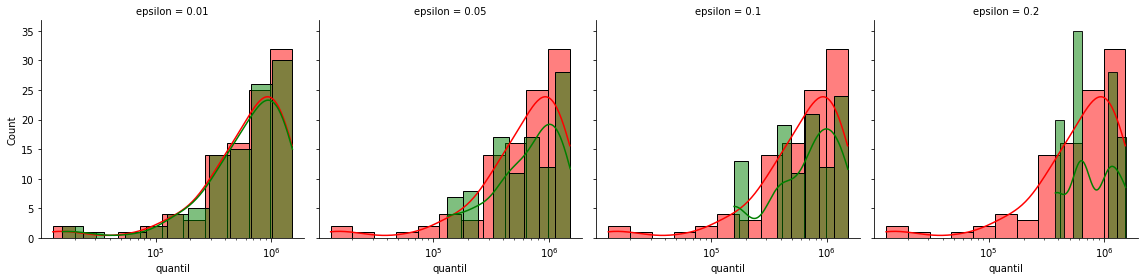

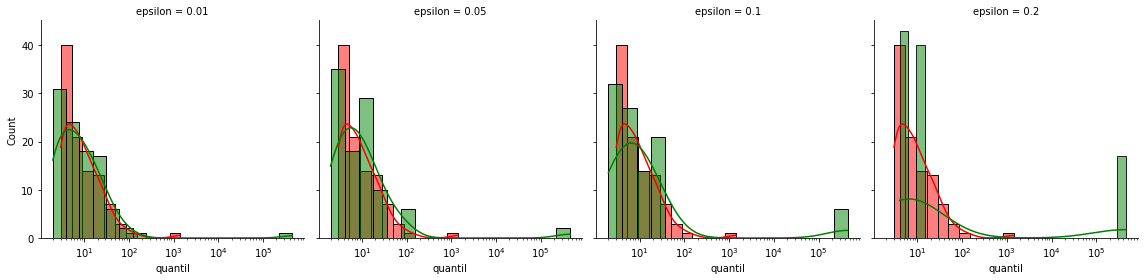

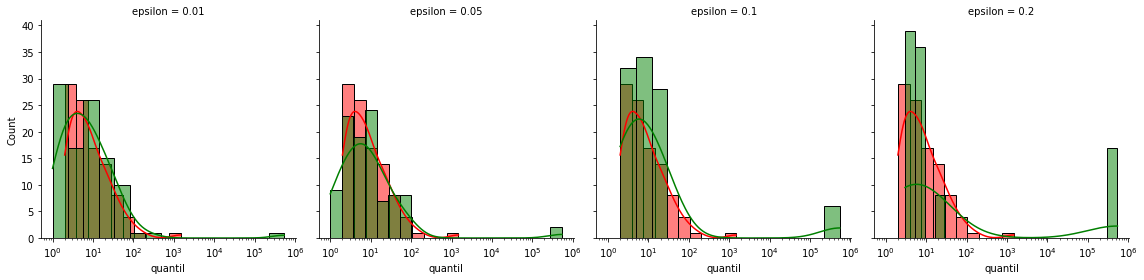

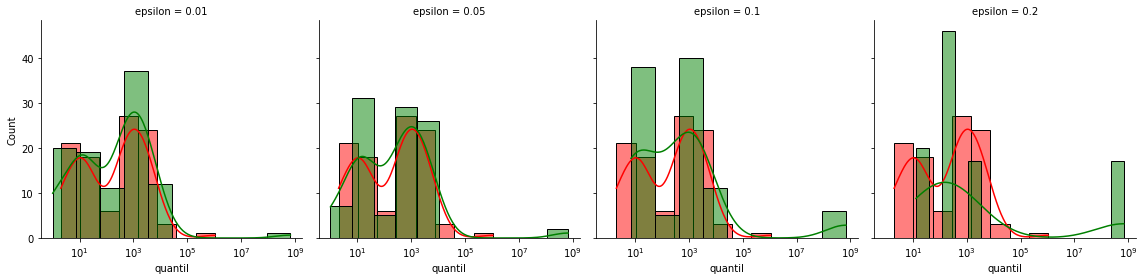

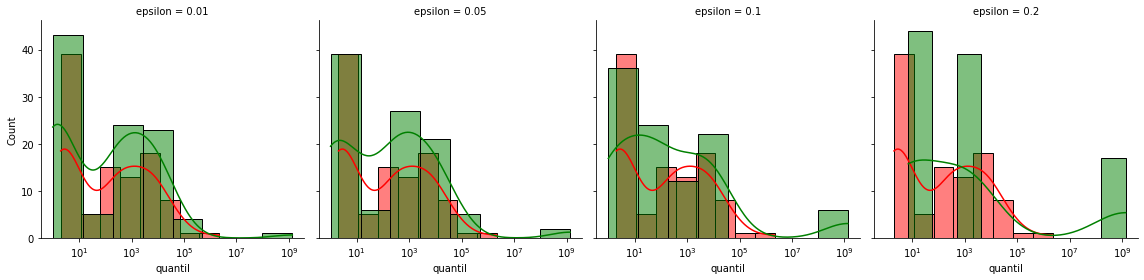

In [27]:
for t in [0, 4, 5, 6, 7]:
    g = sns.FacetGrid( df[(df["target"]==t)], col="epsilon", height=4)
    g.map(sns.histplot, f"{query_type}_baseline", kde=True, color="red", log_scale=True)
    g.map(sns.histplot, query_type, kde=True, color ="green", log_scale=True)
    #g.set(yscale='log')
    g.savefig(f"{BASE_IMG}histograma_xlog_{query_type.upper()}_t_{t}")

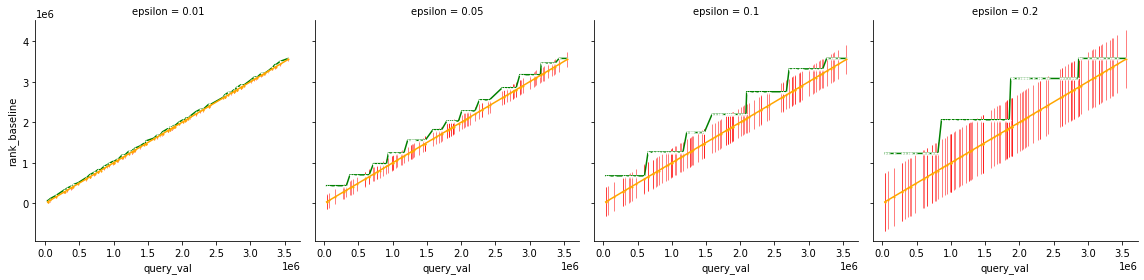

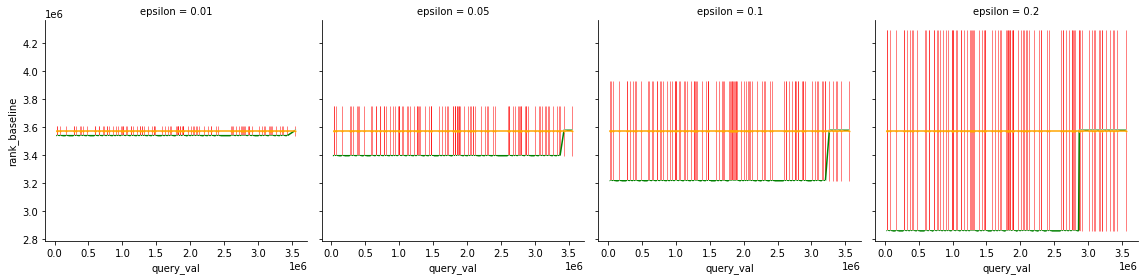

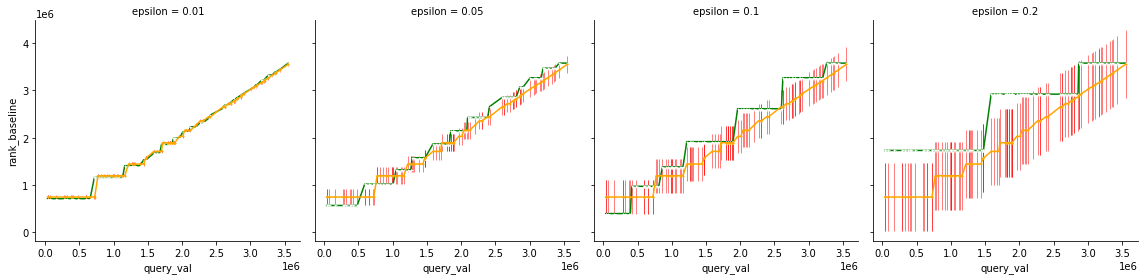

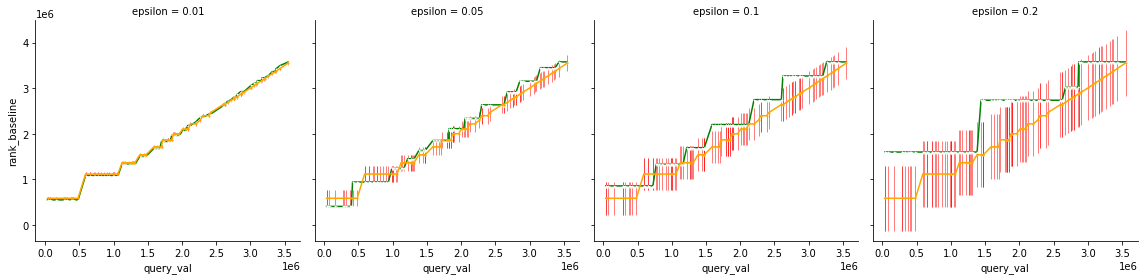

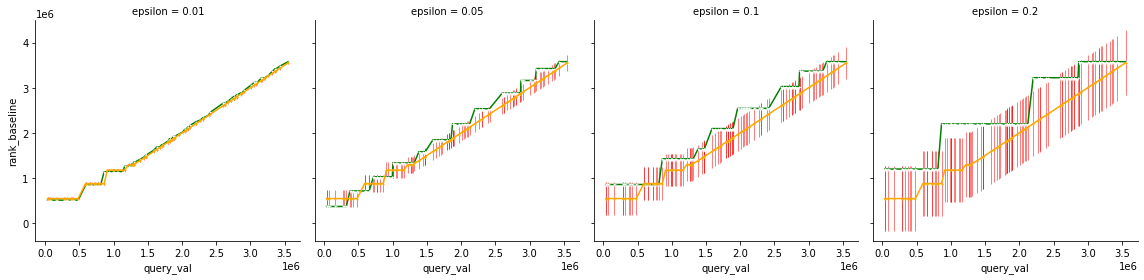

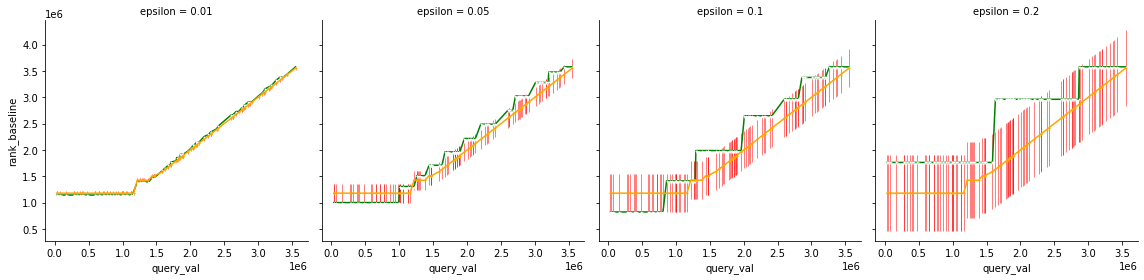

In [21]:
for t in TARGETS:
    g = sns.FacetGrid( df[(df["target"]==t)], col="epsilon", height=4)
    g.map(sns.lineplot, "query_val", "rank", 
          marker="+", color="green", markersize=3)
    g.map(plt.errorbar, "query_val", "rank_baseline", 
          "erro_max", marker=".", ecolor="red", 
          elinewidth=0.5, markersize=2, color="orange")
    g.savefig(f"{BASE_IMG}erroplot_ecdf_{query_type.upper()}_t_{t}")

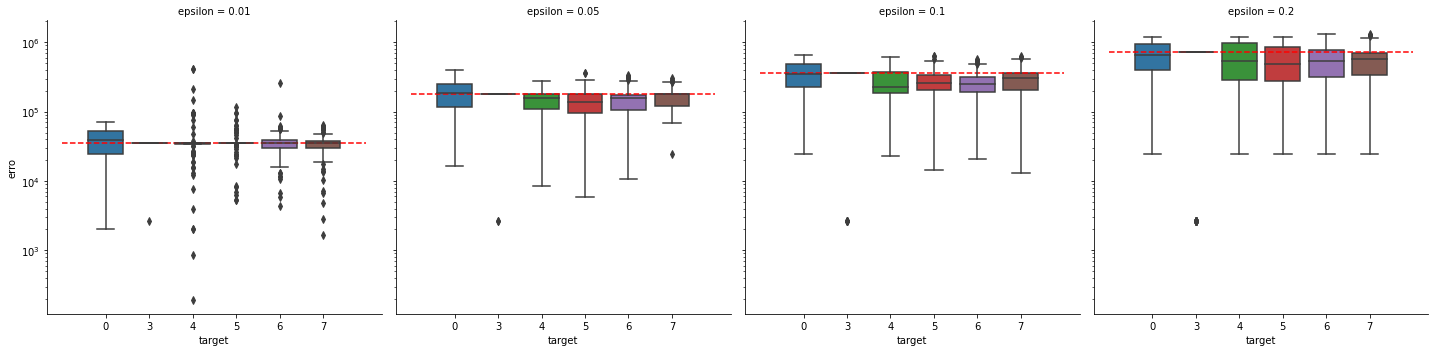

In [22]:
g = sns.catplot(
        data=df, x='target', y="erro",
        col='epsilon', kind='box'
)
#g.set(yscale="log")
for i in range(len(EPS)):
    e=EPS[i]
    g.axes[0][i].hlines(y=M*e,xmin=-1, xmax=len(TARGETS),colors = ["red"], linestyles="dashed")
g.set(yscale="log")
g.savefig(f"{BASE_IMG}boxplot_erros")